In [163]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()   
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
pd.set_option('precision',0)
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
warnings.filterwarnings('ignore')

In [164]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1HQ7yFgpOyTmbe9M73RtT_crS9gowmzGt'
downloaded = drive.CreateFile({'id': file_id})

In [165]:
downloaded.GetContentFile('Total Active Case.xlsx')

In [166]:
!pip install -q xlrd

import pandas as pd
df = pd.read_excel('Total Active Case.xlsx')
df

,Date,New_Positive,Flag_Varian,Total_kasus,Sembuh,Meninggal_Dunia
0,2020-03-02,2,covid,2,0,0
1,2020-03-03,0,covid,2,0,0
2,2020-03-04,0,covid,2,0,0
3,2020-03-05,0,covid,2,0,0
4,2020-03-06,2,covid,4,0,0
...,...,...,...,...,...,...
754,2022-03-27,3077,Omicron,5998953,12499,100
755,2022-03-28,2798,Omicron,6001751,10301,104
756,2022-03-29,3895,Omicron,6005646,10092,108
757,2022-03-30,3840,Omicron,6009486,7876,118


In [167]:
df.describe().style.background_gradient(cmap='prism')

,New_Positive,Total_kasus,Sembuh,Meninggal_Dunia
count,759,759,759,759
mean,7922,1978125,7576,204
std,11915,1880175,10979,337
min,0,2,0,0
25%,908,201688,690,34
50%,4094,1437283,3854,106
75%,7629,4200118,7726,193
max,64718,6012818,61361,2069


In [168]:
lstm_data = df.groupby(['Date']).agg({'New_Positive':'sum'})
lstm_data

,New_Positive
Date,
2020-03-02,2
2020-03-03,0
2020-03-04,0
2020-03-05,0
2020-03-06,2
...,...
2022-03-27,3077
2022-03-28,2798
2022-03-29,3895


In [169]:
# lstm_data['lag1']=lstm_data['New_Positive'].shift(1)
# lstm_data['lag2']=lstm_data['New_Positive'].shift(2)
# lstm_data['lag3']=lstm_data['New_Positive'].shift(3)

In [170]:
import time #helper libraries
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import newaxis
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.model_selection import train_test_split

# MulVar

In [171]:
values = lstm_data.values

In [172]:
# from matplotlib import pyplot
# groups = [0, 1, 2, 3]
# i = 1
# # plot each column
# pyplot.figure()
# for group in groups:
# 	pyplot.subplot(len(groups), 1, i)
# 	pyplot.plot(values[:, group])
# 	pyplot.title(lstm_data.columns[group], y=0.5, loc='right')
# 	i += 1
# pyplot.show()

In [173]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [174]:
from pandas import DataFrame
from pandas import concat
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[0]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var1(t)
1      3e-05    0e+00
2      0e+00    0e+00
3      0e+00    0e+00
4      0e+00    3e-05
5      3e-05    0e+00


In [175]:
# split into train and test sets
values = reframed.values
split = int(len(df) * 0.8)
train = values[:split, :]
test = values[split:, :]
# split into input and outputs
train_X, train_y = train[:, :1], train[:, 1]
test_X, test_y = test[:, :1], test[:, 1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(607, 1, 1) (607,) (151, 1, 1) (151,)


In [176]:
import tensorflow as tf
np.random.seed(1)
tf.random.set_seed(1)

Epoch 1/50
49/49 [==============================] - 3s 19ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - accuracy: 0.0103 - val_loss: 0.1349 - val_mean_squared_error: 0.1349 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/50
49/49 [==============================] - 0s 10ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - accuracy: 0.0103 - val_loss: 0.1349 - val_mean_squared_error: 0.1349 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/50
49/49 [==============================] - 1s 11ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - accuracy: 0.0103 - val_loss: 0.1349 - val_mean_squared_error: 0.1349 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/50
46/49 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063 - accuracy: 0.0109
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
49/49 [==============================] - 1s 11ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - accuracy: 0.0103 - val_loss: 0.1349 - val

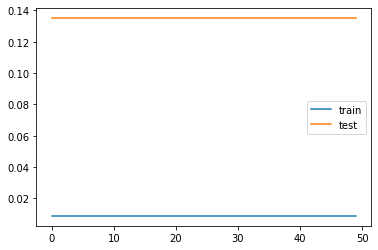

In [177]:
# design network
model = Sequential()
model.add(LSTM(7, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1,activation='relu'))
model.compile(loss = 'mean_squared_error',
                optimizer = 'adam',
                metrics = ['mean_squared_error','accuracy'])
from keras.callbacks import ReduceLROnPlateau
batchsize = 10
epochs =  50
learning_rate_reduction = ReduceLROnPlateau(monitor='val_mean_squared_error', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-10)
# fit network
history = model.fit(train_X,
                    train_y,
                    batch_size=batchsize,
                    validation_data=(test_X, test_y),
                    epochs=epochs,
                    validation_split=0.2,
                    shuffle=False,
                    callbacks=[learning_rate_reduction])

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [178]:
model.get_weights()

[array([[-0.3046364 ,  0.3652346 ,  0.11914951, -0.05954456, -0.18927675,
          0.12963665,  0.43283045, -0.05904114,  0.14564753,  0.09542561,
          0.12429607,  0.10411608,  0.35418487,  0.11622709,  0.02908826,
         -0.43122602, -0.05378702, -0.22499977,  0.35135406,  0.3523277 ,
          0.2613452 , -0.40068337, -0.39018357, -0.17428854, -0.22635353,
          0.37159282, -0.02594545, -0.23435679]], dtype=float32),
 array([[ 0.08118165, -0.20890121,  0.2032398 ,  0.2838764 , -0.03836633,
          0.1318996 ,  0.17553383, -0.2795669 ,  0.3036781 , -0.19323532,
          0.23247352,  0.11353187,  0.15000834, -0.27186686, -0.11639165,
          0.42623535, -0.14632478, -0.1653695 , -0.1796765 , -0.18022265,
          0.06958096, -0.07350175, -0.08141027, -0.1353573 , -0.04760331,
          0.09508672,  0.01345864,  0.22738332],
        [-0.25712454, -0.13079332,  0.13081783, -0.24836466,  0.04245973,
         -0.06252936, -0.25291687, -0.0625143 ,  0.19846448,  0.0064976

# Test

In [179]:
from numpy import concatenate
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


In [180]:
from math import sqrt
from sklearn.metrics import mean_squared_error
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mse = mean_squared_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test RMSE: %.3f' % mse)

Test RMSE: 21296.935
Test RMSE: 453559424.000


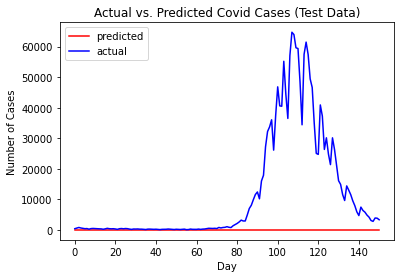

In [181]:
plt.plot(inv_yhat, color='red')
plt.plot(inv_y, color='blue')
plt.title('Actual vs. Predicted Covid Cases (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend(['predicted', 'actual']) 

# Train

In [182]:
# make a prediction
yhat1 = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
# invert scaling for forecast
inv_yhat1 = concatenate((yhat1, train_X[:, 1:]), axis=1)
inv_yhat1 = scaler.inverse_transform(inv_yhat1)
inv_yhat1 = inv_yhat1[:,0]
# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y1 = concatenate((train_y, train_X[:, 1:]), axis=1)
inv_y1 = scaler.inverse_transform(inv_y1)
inv_y1 = inv_y1[:,0]


In [183]:
los=history.history['loss']
acc=history.history['accuracy']
vlos=history.history['val_loss']
vacc=history.history['val_accuracy']

In [184]:
from math import sqrt
from sklearn.metrics import mean_squared_error
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y1, inv_yhat1))
mse = mean_squared_error(inv_y1, inv_yhat1)
print('Train RMSE: %.3f' % rmse)
print('Train MSE: %.3f' % mse)

Train RMSE: 11955.412
Train MSE: 142931888.000


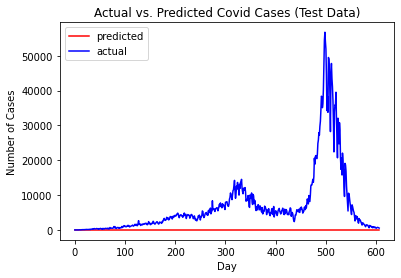

In [185]:
plt.plot(inv_yhat1, color='red')
plt.plot(inv_y1, color='blue')
plt.title('Actual vs. Predicted Covid Cases (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend(['predicted', 'actual']) 

MAPE
MAPE	Interpretation
< 10 %	Very good
10 % - 20 %	Good
20 % - 50 %	OK > 50 %	Not good

In [186]:
#Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [187]:
# Using MAPE error metrics to check for the error rate and accuracy level
LR_MAPE= MAPE(inv_y,inv_yhat)
print("MAPE: ",LR_MAPE)

MAPE:  100.0


In [188]:
coba1=inv_y1+1
coba2=inv_yhat1+1
# Using MAPE error metrics to check for the error rate and accuracy level
RR_MAPE= MAPE(coba1,coba2)
print("MAPE: ",RR_MAPE)

MAPE:  98.92071485519409


In [189]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print('R2 Score: ', r2_score(inv_y, inv_yhat))

R2 Score:  -0.43351576341028064
